# Goodness of fit

To demonstrate the us of the goodness-of-fit tools introdcued in the notebook #2 (posterior predictive checks), let's examine the case where our model does not provide a good description of the data.   

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import arviz as av

from instrument_response.toy_simulation import ToySimulation
from instrument_response.detector import Response
from instrument_response.power_law import BrokenBoundedPowerLaw, BoundedPowerLaw

from cmdstanpy import CmdStanModel

This time, let's use our toy simulation to simulate data from a broken power law spectrum, that looks like the following:

In [2]:
random_seed = 1

min_energy = 1 
break_energy = 5
max_energy = 100
spectral_index_1 = 2.0
spectral_index_2 = 6.0

Text(0.5, 0, 'E [TeV]')

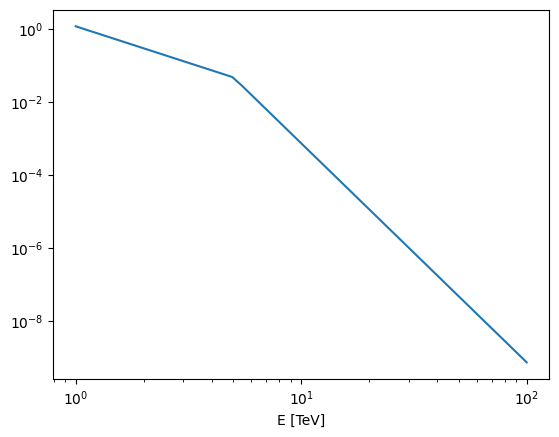

In [3]:
bpl = BrokenBoundedPowerLaw(min_energy, break_energy, max_energy, -spectral_index_1, -spectral_index_2)  

E_grid = np.geomspace(min_energy, max_energy)
fig, ax = plt.subplots()
ax.plot(E_grid, bpl.pdf(E_grid))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")

We can do this by using the keyword `bpl=True` in our `ToySimulation` class. The only extra parameter we need to pass is the first spectral index of the power law at low energies. The other parameters (`break_energy`, `spectral_index_2`) are already hard coded for the purpose of this demo. 

In [4]:
N = int(3e3) # Let's simulate some more data this time
data_file = "output/toy_sim_data_bpl.h5"

simulation = ToySimulation(spectral_index_1, min_energy, max_energy, bpl=True)
simulation.run(N, seed=random_seed)
simulation.save(data_file)

The detector response is the same as before, so let's load that, as in notebook #2.

In [5]:
with h5py.File("output/response_sim.h5", 'r') as f:
    initial_energy = f["initial_energy"][()]
    true_energy = f["true_energy"][()]
    detected_energy = f["detected_energy"][()]

response = Response(initial_energy, true_energy, detected_energy,
                        simulation.effective_area.maximum,
                        nbins_true_energy=50, detected_energy_bins=50)

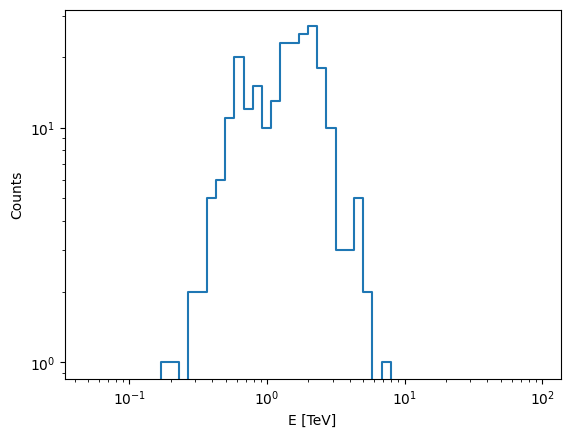

In [6]:
# Have a look at our "data"
with h5py.File("output/toy_sim_data_bpl.h5", 'r') as f:
    detected_energy = f['detected_energy'][()]

Edet_bins = response.detected_energy_bins

counts, _ = np.histogram(detected_energy, bins=Edet_bins)

fig, ax = plt.subplots()
ax.step(Edet_bins[:-1], counts, where="pre")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel("Counts");

We know this data is from a broken power law, and we can check the model prediction in this case:

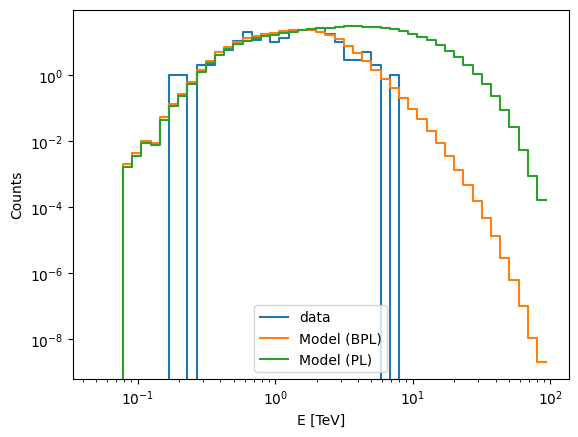

In [7]:
# Normalise our model to match the simulated flux
def differential_flux(e, F_N, pl):
    return F_N * pl.pdf(e)

# integral of the differential flux (Simpson's rule)
def integral(e1, e2, F_N, pl):
    return ((e2 - e1) / 6.0) * (differential_flux(e1, F_N, pl) 
                              + 4 * differential_flux((e1 + e2) / 2.0, F_N, pl) 
                              + differential_flux(e2, F_N, pl))

# For our model, calculate the rate in each true energy bin
counts_per_area = integral(response.true_energy_bins[:-1], response.true_energy_bins[1:], simulation.total_dN_dtdA, bpl)

# Get folded counts in the detector by taking the dot product with the response
counts_model = np.dot(counts_per_area, response.matrix) 

# Same for a power law only, for comparison
pl = BoundedPowerLaw(spectral_index_1, min_energy, max_energy)
counts_per_area_pl = integral(response.true_energy_bins[:-1], response.true_energy_bins[1:], simulation.total_dN_dtdA, pl)
counts_model_pl = np.dot(counts_per_area_pl, response.matrix) 

# Compare folded model and data
fig, ax = plt.subplots()

dE = np.diff(response.detected_energy_bins)
ax.step(Edet_bins[:-1], counts, where="pre", label="data")
ax.step(Edet_bins[:-1], counts_model, where="pre", label="Model (BPL)")
ax.step(Edet_bins[:-1], counts_model_pl, where="pre", label="Model (PL)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel("Counts")
ax.legend();

Looks good. Now, let's try to fit a model to the data. Unfortunately, we only have the Stan code `binned_likelihood.stan` to fit a simple power law... so let's see how it goes. 

In [8]:
# Compile the Stan model
model = CmdStanModel(stan_file="stan/binned_likelihood.stan")

# Run the fit
fit_input = {}
fit_input["Nbins_true"] = response.nbins_true_energy
fit_input["Nbins_detected"] = response.nbins_detected_energy
fit_input["min_energy"] = 1 # TeV
fit_input["max_energy"] = 100 # TeV
fit_input["response_matrix"] = response.matrix
fit_input["true_energy_bins"] = response.true_energy_bins
fit_input["detected_energy_bins"] = response.detected_energy_bins

fit_input["n"] = counts

fit = model.sample(data=fit_input, iter_sampling=1000, chains=4)

16:40:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:41:07 - cmdstanpy - INFO - CmdStan done processing.


In [9]:
# check the results
print(fit.diagnose())
fit.summary()

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-99.692300,3.174340e-02,1.052550,0.729439,-101.745000,-99.372700,-98.707500,1514.21,1386.16,1.00331
F_N,4.886960,2.294960e-03,0.105281,0.078897,4.674810,4.919010,4.992560,1495.02,1212.35,1.00112
alpha,2.879030,1.529180e-03,0.064492,0.064323,2.771550,2.879270,2.983880,1797.97,1737.34,1.00107
model_flux[1],0.776536,8.064980e-04,0.032531,0.030831,0.720068,0.779162,0.824733,1695.78,2035.65,1.00106
model_flux[2],0.653002,5.982580e-04,0.024093,0.022584,0.609993,0.655661,0.687511,1694.64,2159.88,1.00113
...,...,...,...,...,...,...,...,...,...,...
s[46],0.003468,1.910870e-05,0.000821,0.000796,0.002290,0.003379,0.004964,1852.55,1830.97,1.00122
s[47],0.000975,5.502490e-06,0.000236,0.000229,0.000638,0.000949,0.001407,1850.84,1830.97,1.00124
s[48],0.000199,1.139380e-06,0.000049,0.000047,0.000129,0.000193,0.000288,1850.28,1830.97,1.00124
s[49],0.000029,1.725970e-07,0.000007,0.000007,0.000019,0.000028,0.000043,1849.21,1830.97,1.00122


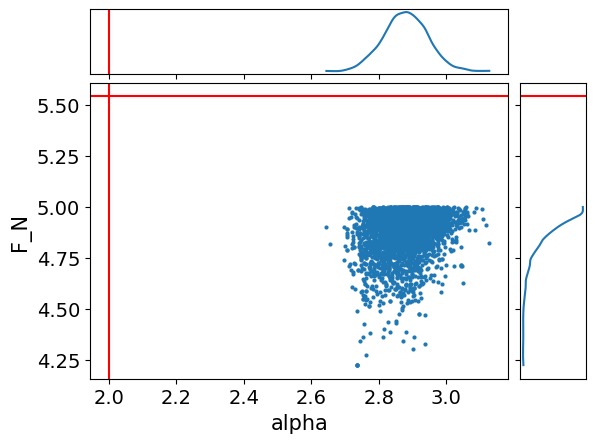

In [10]:
# Load true values from simulation
with h5py.File("output/toy_sim_data_bpl.h5", 'r') as f:
    true_alpha = f["power_law_index"][()]
    true_F_N = f["flux_normalisation"][()]

ax = av.plot_pair(fit, var_names=["alpha", "F_N"], marginals=True)
ax[0,0].axvline(true_alpha, color="red")
ax[1,0].axvline(true_alpha, color="red")
ax[1,0].axhline(true_F_N, color="red")
ax[1,1].axhline(true_F_N, color="red")

So, the fit runs well and doesn't report any sampling issues, but we cannot recover the true values of the fit. This is not surprising really given we know that we have simulated data from a *broken power law*, and our model only allows us to describe a *power law*.

<br>

We can investigate this in more detail by comparing the model prediction and the known truth:

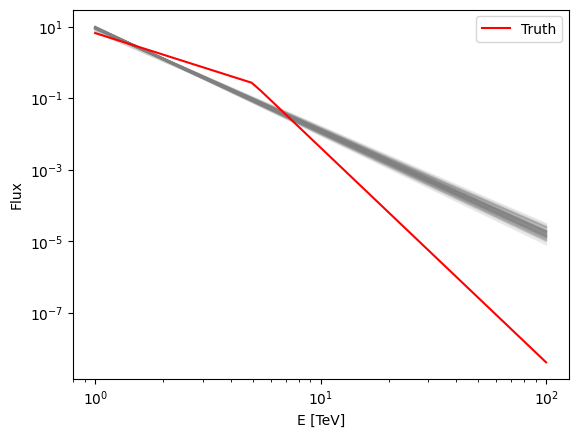

In [11]:
# Values of F_N and alpha from the fit
fit_alpha = fit.stan_variable("alpha")
fit_F_N = fit.stan_variable("F_N")

energy_grid = np.geomspace(min_energy, max_energy)

fig, ax = plt.subplots()

# Evaluate the model for first 100 samples
for i in range(100):
    power_law_tmp = BoundedPowerLaw(fit_alpha[i], min_energy, max_energy)
    ax.plot(energy_grid, fit_F_N[i] * power_law_tmp.pdf(energy_grid), color="grey", alpha=0.1)

# Truth from plot above
ax.plot(energy_grid, true_F_N * bpl.pdf(energy_grid), color="red", label="Truth") 

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel("Flux")
ax.legend()

**Exercise 3.1:** Use the code that you wrote to solve the exercise in notebook #2 to perform a goodness-of-fit check (posterior predictive check) for this fit. Both visualise and quantify your results.